## Se buscan pares prometedores en función de unos parámetros dados (distancia, ángulo)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Definir función para calcular la distancia entre la línea que pasa por dos hits y el origen
def distance_from_origin(hit1, hit2):
    direction = hit2 - hit1
    origin_distance = np.linalg.norm(np.cross(hit1, direction)) / np.linalg.norm(direction)
    return origin_distance

# Definir la función para calcular el ángulo entre dos vectores
def angle_between_vectors(v1, v2):
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))  # Para evitar valores fuera de rango

def pair_is_good(pair):
    ''' Consideraciones de si un para es bueno o no en función de la distancia y ángulo '''
    origin_dist, angle = pair
    # Definir una regla arbitraria: por ejemplo, que el par sea "bueno" si la distancia es pequeña y el ángulo es cercano a 0
    if angle > np.arccos(0.95):
        return True
    return False

#print(f"hits_dict_all_volumes: {hits_dict_all_volumes}")

n_volumes = 3  # Número de volúmenes 
limited_volumes = list(hits_dict_all_volumes.items())[:n_volumes]

pairs = []
for volume_id, volume_hits in limited_volumes:
    print(f"Processing volume {volume_id}")
    
    # Ordenar las claves de las capas (si no son consecutivas, esto las organizará correctamente)
    sorted_layers = sorted(volume_hits.keys())
    
    # Iterar sobre las capas y emparejarlas con la siguiente capa disponible
    for i in range(len(sorted_layers) - 1):  # Excluimos la última capa porque no tiene siguiente   
        layer = sorted_layers[i]
        next_layer = sorted_layers[i + 1]
        
        print(f"Processing layer {layer} and next layer {next_layer} in volume {volume_id}")
        
        # Obtener los hits de la capa actual y la siguiente
        layer_hits = volume_hits[layer]
        next_layer_hits = volume_hits[next_layer]
        
        # Verificar si hay hits en ambas capas
        if len(layer_hits) == 0 or len(next_layer_hits) == 0:
            print(f"No hits in one of the layers {layer} or {next_layer} for volume {volume_id}")
            continue
        
        # Generar pares de hits entre las capas adyacentes
        for hit1 in layer_hits.itertuples():
            for hit2 in next_layer_hits.itertuples():

                hit1_pos = np.array([hit1.x, hit1.y, hit1.z])
                hit2_pos = np.array([hit2.x, hit2.y, hit2.z])
                
                # Calcular la distancia desde el origen y el ángulo entre los hits
                origin_dist = distance_from_origin(hit1_pos, hit2_pos)
                angle = angle_between_vectors(hit1_pos, hit2_pos)
                
                # Guardar el par de hits con sus características
                pairs.append([hit1_pos, hit2_pos, hit1.layer_id, hit2.layer_id, origin_dist, angle])  

#print(hits_dict_all_volumes)

# Verificar si realmente se generaron pares
print(f"Total pairs generated: {len(pairs)}")
if len(pairs) == 0:
    print("No pairs were generated. Check your data.")

# Convertir a un formato adecuado para regresión logística
X_pairs = np.array([[pair[4], pair[5]] for pair in pairs])  # Tomo caaracterísticas: distancia y ángulo
y_pairs = np.array([1 if pair_is_good(pair[4:]) else 0 for pair in pairs])

# Verificar la forma de X_pairs y y_pairs
print(f"X_pairs.shape: {X_pairs.shape}")
print(f"y_pairs.shape: {y_pairs.shape}")

# Asegurarse de que X_pairs y y_pairs no están vacíos y tienen la forma adecuada
if X_pairs.shape[0] > 0 and X_pairs.shape[1] == 2 and y_pairs.shape[0] == X_pairs.shape[0]:
    # Regresión logística para hacer pruning
    clf = LogisticRegression(max_iter=1000)  
    clf.fit(X_pairs, y_pairs)

    # Filtrar los pares usando el modelo entrenado
    promising_pairs = [pair for pair, score in zip(pairs, clf.predict_proba(X_pairs)[:, 1]) if score > 0.9]
    print(f'==== Se han generado un total de {len(promising_pairs)} pares prometedores con una score mayor a 0.9 sobre una regresión logísitica ====')
else:
    print("Los datos de entrada no tienen la forma adecuada para el modelo.")

print(promising_pairs[0])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for pair in tqdm(promising_pairs, desc = 'Procesando pares'):
    ax.scatter(pair[0], pair[1], color='r', label='Hits originales')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


Processing volume 8
Processing layer 2 and next layer 4 in volume 8


KeyboardInterrupt: 

## Se extienden los pares generados a triples con la siguiente capa, de los que se trazará la hélice

Buscando hits en la capa 6...
Encontrados 234 hits en la capa siguiente.
       hit_id           x           y      z  volume_id  layer_id  module_id  \
53668   53669   91.377899    3.053840  822.5          9         6         55   
52725   52726  -35.668301 -130.886002  818.0          9         6         22   
53794   53795   33.623199    8.758770  822.0          9         6         60   
54799   54800  -34.065899   13.398900  822.5          9         6         98   
52592   52593   -9.367520  -30.071100  822.0          9         6         17   
...       ...         ...         ...    ...        ...       ...        ...   
52219   52220  -43.112400  -10.016100  818.0          9         6          4   
53242   53243   71.402802  -78.721298  818.0          9         6         41   
53913   53914   30.929300   17.769400  822.5          9         6         66   
52959   52960   24.619600 -123.473000  822.0          9         6         30   
52481   52482 -130.065994 -108.362999  818.0   

Procesando triples: 100%|██████████| 4329/4329 [00:20<00:00, 212.38it/s]


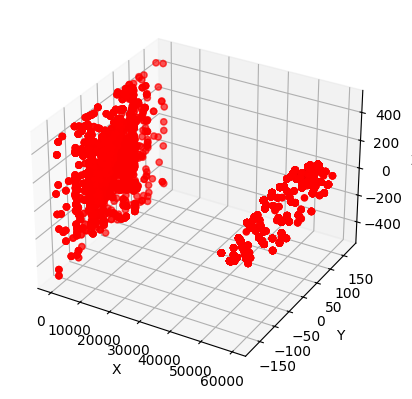

In [ ]:
def get_next_layer_hits(layer1, layer2, volume_hits):
    '''Obtiene la siguiente capa al par de hits, considerando saltos de dos en dos'''
    next_layer_hits = []

    # Comprobar si la siguiente capa existe
    if layer2 == layer1 + 2:
        next_layer = layer2 + 2  # Sigue el patrón de saltos
        print(f"Buscando hits en la capa {next_layer}...")  # Agregar log para depuración
        if next_layer in volume_hits:
            next_layer_hits = volume_hits[next_layer]
            print(f"Encontrados {len(next_layer_hits)} hits en la capa siguiente.")  # Agregar log para depuración
        else:
            print(f"No se encontraron hits en la capa {next_layer}.")  # Agregar log para depuración
        
        #print(next_layer_hits)
    
    return next_layer_hits

def extend_to_next_layer(hit1, hit2, next_layer_hits):
    '''Extendemos la dirección entre hits a la siguiente capa y sacamos los 10 hits más cercanos'''
    direction = hit2 - hit1  # Calculamos la dirección entre los dos hits
    extended_hit = hit2 + direction  # Extender la línea en la misma dirección

    print(f"Extending direction from hit1 to hit2: {hit1} -> {hit2}. Extended hit: {extended_hit}") 
    
    # Asegurarnos de que next_layer_hits contiene solo las coordenadas (si tiene más columnas, las eliminamos)
    next_layer_hits_coords = next_layer_hits.iloc[:, 1:4].values  # Usar .iloc para obtener las primeras 3 columnas y convertir a numpy array
    print(f"next_layer_hits_coords shape: {next_layer_hits_coords.shape}")  # Verificar forma
    
    # Calcular distancias entre los hits de la siguiente capa y el hit extendido
    distances = np.linalg.norm(next_layer_hits_coords - extended_hit, axis=1)  # Calcular distancias
    closest_hits = next_layer_hits.iloc[np.argsort(distances)[:10]]  # Encontrar los hits más cercanos
    return closest_hits[:3]

# Generación de tríos a partir de los pares prometedores
triples = []
for pair in promising_pairs:
    hit1, hit2, layer1, layer2, _, _ = pair  # Extrae hit1, hit2 y sus capas correctamente
    next_layer_hits = get_next_layer_hits(layer1, layer2, volume_hits)  # Pasa layer1 y layer2

    print(f"Hit1 en capa {layer1}, Hit2 en capa {layer2}, Hits en capa siguiente: {len(next_layer_hits)}")
    
    if len(next_layer_hits) > 0:  # Comprobar si hay hits en la siguiente capa
        closest_hits = extend_to_next_layer(hit1, hit2, next_layer_hits)
        for hit3 in closest_hits.values:
            triples.append([hit1, hit2, hit3])  # Guardar el trío
    else:
        print(f"No hay hits para formar triples de la capa {layer1} y {layer2}.")

# Ahora tienes una lista de triples candidatos
print(f"\n========== Total de triples generados: {len(triples)} ==========")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for triple in tqdm(triples, desc = 'Procesando triples'):
    ax.scatter([hit[0] for hit in triple], [hit[1] for hit in triple], [hit[2] for hit in triple], color='r', label='Hits originales')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Fit del triple a una hélice

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función de ajuste de la hélice
def helix_fit(params, hits):
    '''Ajuste de la hélice a 3 hits usando un modelo simple (parametrización en forma de helix)'''
    x0, y0, z0, r, pitch = params  # Parámetros: centro (x0, y0, z0), radio r, y paso (pitch)
    
    # Calcular las posiciones esperadas en la hélice a partir de los parámetros
    t = np.linspace(0, 2 * np.pi, 3)  # 3 puntos (3 hits)
    x = x0 + r * np.cos(t)
    y = y0 + r * np.sin(t)
    z = z0 + pitch * t  # La posición en z es linealmente creciente
    
    # Calculamos el error cuadrático total
    error = np.sum((hits[:, 0] - x) ** 2 + (hits[:, 1] - y) ** 2 + (hits[:, 2] - z) ** 2)
    return error

def fit_helix(hits):
    '''Ajusta una hélice a 3 hits y devuelve los parámetros ajustados'''
    # Initial guess for the center (x0, y0, z0), radius r, and pitch (step) of the helix
    initial_params = [0, 0, 0, 5, 1]
    
    # Minimizamos el error de ajuste de la hélice
    result = minimize(helix_fit, initial_params, args=(hits,), method='Nelder-Mead')
    
    # Los parámetros óptimos de la hélice
    x0, y0, z0, r, pitch = result.x
    return x0, y0, z0, r, pitch

def extend_helix(x0, y0, z0, r, pitch, n_layers):
    '''Extiende la hélice hacia capas siguientes'''
    z_values = np.linspace(z0, z0 + n_layers * pitch, n_layers)
    x_values = x0 + r * np.cos(z_values / r)
    y_values = y0 + r * np.sin(z_values / r)
    
    return np.column_stack((x_values, y_values, z_values))

# Extender la hélice para los triples generados
def generate_tracks(triples, volume_hits, n_layers):
    extended_tracks = []
    
    for triple in tqdm(triples, desc = 'Generando tracks'):
        hit1, hit2, hit3 = triple  # Extraer los tres hits del trío
        
        # Asegurarse de que cada hit tenga la forma [x, y, z], tomar solo las primeras 3 coordenadas
        hit1 = hit1[:3]  
        hit2 = hit2[:3]  
        hit3 = hit3[:3]  
        
        # Asegurarse de que todos los hits tengan la forma [x, y, z]
        hits = np.array([hit1, hit2, hit3])  # Asegúrate de que cada hit tiene la forma [x, y, z]
        
        # Ajustar la hélice a los 3 hits
        x0, y0, z0, r, pitch = fit_helix(hits)
        
        # Extender la hélice hacia las siguientes capas
        extended_hits = extend_helix(x0, y0, z0, r, pitch, n_layers)
        
        # Añadir los hits extendidos a la lista de tracks generados
        extended_tracks.append(extended_hits)
    
    return extended_tracks

# Visualización de los resultados
def plot_tracks(extended_tracks, triples):
    '''Visualiza los hits originales y las hélices extendidas en 3D'''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficar cada track extendido
    for extended_hits in tqdm(extended_tracks, desc = 'Procesando tracks'):
        ax.plot(extended_hits[:, 0], extended_hits[:, 1], extended_hits[:, 2], color='b', alpha=0.5)  # Hélice extendida
    
    # Graficar los hits originales (en rojo)
    for triple in tqdm(triples, desc = 'Procesando triples'):
        ax.scatter([hit[0] for hit in triple], [hit[1] for hit in triple], [hit[2] for hit in triple], color='r', label='Hits originales')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # plt.legend()
    plt.show()

print(f"Total de triples generados: {len(triples)}")
print(f"Primeros triples: {triples[:5]}")  

# Suponiendo que ya tienes los triples generados, usa esta función para extender y graficar
n_layers = 4
extended_tracks = generate_tracks(triples, volume_hits, n_layers)
print(f'len(extended_tracks):    {len(extended_tracks)}')

# Visualización de los resultados
#plot_tracks(extended_tracks, triples)


Total de triples generados: 14430
Primeros triples: [[array([10.97920036, 29.60860062, 24.94599915]), array([-28.39100075, -65.79319763, -53.58240128]), array([ 5.28690000e+04, -2.65025997e+01, -1.73162003e+02,  8.18000000e+02,
        9.00000000e+00,  6.00000000e+00,  2.60000000e+01,  8.36547363e+02])], [array([10.97920036, 29.60860062, 24.94599915]), array([-28.39100075, -65.79319763, -53.58240128]), array([ 5.27260000e+04, -3.56683006e+01, -1.30886002e+02,  8.18000000e+02,
        9.00000000e+00,  6.00000000e+00,  2.20000000e+01,  8.29172729e+02])], [array([10.97920036, 29.60860062, 24.94599915]), array([-28.39100075, -65.79319763, -53.58240128]), array([ 5.25480000e+04, -1.07176003e+02, -1.32158997e+02,  8.18000000e+02,
        9.00000000e+00,  6.00000000e+00,  1.60000000e+01,  8.35509827e+02])], [array([10.97920036, 29.60860062, 24.94599915]), array([-28.39100075, -65.79319763, -53.58240128]), array([ 5.28670000e+04, -1.97010994e+01, -1.17528000e+02,  8.18000000e+02,
        9.000

Generando tracks: 100%|██████████| 14430/14430 [12:39<00:00, 19.00it/s]

len(extended_tracks):    14430


Procesando triples:   0%|          | 0/14430 [00:00<?, ?it/s]

Procesando triples: 100%|██████████| 14430/14430 [00:59<00:00, 243.69it/s]


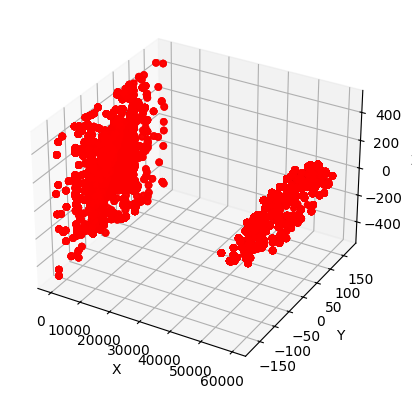

In [ ]:
def plot_tracks(triples):
    '''Visualiza los hits originales y las hélices extendidas en 3D'''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for triple in tqdm(triples, desc = 'Procesando triples'):
        ax.scatter([hit[0] for hit in triple], [hit[1] for hit in triple], [hit[2] for hit in triple], color='r', label='Hits originales')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # plt.legend()
    plt.show()
    
plot_tracks(triples)
